# Class 10: Optimization and Pyomo

&#169; University of Notre Dame. CBE 20258. Spring 2020.

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: You are expected to read this entire notebook before class.
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyomo.environ import *

## 10e. Optimal Operation of Battery Energy Storage

Grid-scale battery energy storage systems (BESS) are expected to play a critical role in supporting wide-spread adoption of renewable electricity. In an effort to *future proof* their electric grid, California has mandated over **1 GW** of BESS power capacity be brought online by 2020. For context, the peak electricity demand in California during 2016 was 46.2 GW: https://www.caiso.com/Documents/CaliforniaISOPeakLoadHistory.pdf}

For policy-makers, technology developers, and investors, there is a critical need to understand the true value of energy storage systems. In California and many regions throughout the United States, electricity is purchased and sold in a wholesale market with time-varying prices (units of \$ / MWh). In principle, a smart battery operator wants to **buy low** (charge) and **sell high** (discharge). This is known as energy arbitrage. 

### 10e-i. Visualize Price Data

The text file `Prices_DAM_ALTA2G_7_B1.csv` contains an entire year of wholesale energy prices for Chino, CA. Let's import and inspect the data using Pandas. Our text file contains only one column and no header. We will manually specify "Price" as the name for the single column.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Run the code below.
</div>

In [11]:
data = pd.read_csv('Prices_DAM_ALTA2G_7_B1.csv',names=['Price'])
data.head()

,Price
0,36.757
1,34.924
2,33.389
3,32.035
4,33.694


Let's compute some summary statistics.

In [12]:
data.describe()

,Price
count,8760.000000
mean,32.516994
std,9.723477
min,-2.128700
25%,26.510000
50%,30.797500
75%,37.544750
max,116.340000


Let's make a histogram.

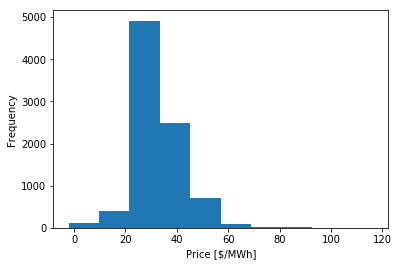

In [13]:
plt.hist(data['Price'])
plt.xlabel("Price [$/MWh]")
plt.ylabel("Frequency")
plt.show()

Finally, let's plot the prices for the first three days in the data set.

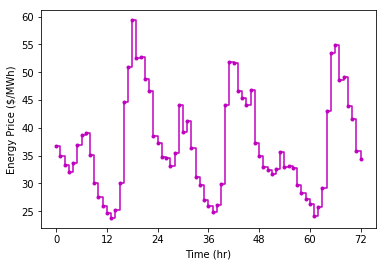

In [14]:
# determine number of hours to plot
nT = 3*24

# determine hour we should start counting
# 0 means start counting at the first hour, i.e., midnight on January 1, 2015
t = 0 + np.arange(nT+1)
price_data = data["Price"][t]

# Make plot.
plt.figure()
plt.step(t,price_data,'m.-',where='post')
plt.xlabel('Time (hr)')
plt.ylabel('Energy Price ($/MWh)')
plt.xticks(range(0,nT+1,12))
plt.show()

### 10e-ii. Create Mathematical Model

For simplicity, assume a battery energy storage system is *price-taker*, i.e., they are subject to the market price but their actions do not influence the market price. During each hour $t$, the battery operator decided to either charge (buy energy) or discharge (sell energy) at rates $c_t$ and $d_t$ (units: MW), respectively, subject to the market price $p_t$ (units: \$/MWh). Assume the battery has a round trip efficiency of $\eta = 88\%$. Let $E_t$ represent the state-of-charge at time $t$ (units: MW).

![battery](battery.png)

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Using the picture above, sketch the battery system. Label $d_t$, $c_t$, $E_t$, and $p_t$ on your sketch. Verify the units are consistent.
</div>

We can now write a constrained optimization problem to compute the optimal market participation strategy (when to buy and sell).

\begin{align*}
    \max_{E,d,c} \quad & \psi := \sum_{t = 1}^{N} p_{t} (d_{t} - c_{t}) \\
\mathrm{s.t.} \quad & E_{t} = E_{t-1} + c_{t} \sqrt{\eta} - \frac{d_{t}}{\sqrt{\eta}}, ~~ \forall ~ t \in \{1,...,N\} \\
    & 0 \leq c_{t} \leq c_{max}, ~~ 0 \leq d_{t} \leq d_{max}, \nonumber \\
    & 0 \leq E_{t} \leq E_{max},  ~~\forall ~ t \in \{1,...,N\}
\end{align*}

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Discuss the optimization problem above with a partner. Then, write a few sentences to explain each equation.
</div>

### 10e-iii. Define Pyomo Model

We can now write the optimization problem in Pyomo. We will create a set `TIME` to write the model compactly.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Finish the Pyomo model below.
</div>

In [15]:
# define a function to build model
def build_model(price,e0 = 0):
    '''
    Create optimization model for battery operation

    Inputs:
        price: Pandas DataFrame with energy price timeseries
        e0: initial value for energy storage level
    
    Output:
        model: Pyomo optimization model
    '''
    
    # Create a concrete Pyomo model. We'll learn more about this in a few weeks
    model = ConcreteModel()

    ## Define Sets

    # Number of timesteps in planning horizon
    model.TIME = Set(initialize = price.index)

    ## Define Parameters

    # Square root of round trip efficiency
    model.sqrteta = Param(initialize = sqrt(0.88))

    # Energy in battery at t=0
    model.E0 = Param(initialize = e0, mutable=True)

    # Charging rate [MW]
    model.c = Var(model.TIME, initialize = 0.0, bounds=(0, 1))

    ### BEGIN SOLUTION
    # Discharging rate [MW]
    model.d = Var(model.TIME, initialize = 0.0, bounds=(0, 1))

    # Energy (state-of-charge) [MWh]
    model.E = Var(model.TIME, initialize = 0.0, bounds=(0, 4))
    ### END SOLUTION
    
    ## Define constraints
    
    # Define Energy Balance constraints. [MWh] = [MW]*[1 hr]
    # Note: this model assumes 1-hour timestep in price data and control actions.
    def EnergyBalance(model,t):
        # First timestep
        if t == 0 :
            return model.E[t] == model.E0 + model.c[t]*model.sqrteta-model.d[t]/model.sqrteta 
        
        # Subsequent timesteps
        else :
            ### BEGIN SOLUTION
            return model.E[t] == model.E[t-1]+model.c[t]*model.sqrteta-model.d[t]/model.sqrteta
            ### END SOLUTION
    
    model.EnergyBalance_Con = Constraint(model.TIME, rule = EnergyBalance)
    
    ## Define the objective function (profit)
    # Receding horizon
    def objfun(model):
        return  sum((-model.c[t] + model.d[t]) * price[t] for t in model.TIME)
    model.OBJ = Objective(rule = objfun, sense = maximize)
    
    return model

### 10e-iv. Solve Optimization Model

We can now create an instance of our Pyomo model. Notice the function `build_model` requires we pass in a Pandas DataFrame with the price data. Let's try the first day only.

In [16]:
# Build the model
instance = build_model(data["Price"][0:24],0.0)

# Specify the solver
solver = SolverFactory('ipopt')

# Solve the model
results = solver.solve(instance, tee = True)

Ipopt 3.12.8: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       95
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       72
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       72
                     variables with only upper bounds:        0
Total

### 10e-v. Extract Solution from Pyomo

Excellent. Ipopt terminated with the message `Optimal Solution Found`. Let's inspect the answer.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Run the code below.
</div>

In [17]:
# Declare empty lists
c_control = []
d_control = []
E_control = []
time = []

# Loop over elements of TIME set.
for i in instance.TIME:    
    # Record the time
    time.append(value(i))
    
    # Use value( ) function to extract the solution for each varliable and append to the results lists
    c_control.append(value(instance.c[i]))
    
    # Adding negative sign to discharge for plotting
    d_control.append(-value(instance.d[i]))
    E_control.append(value(instance.E[i]))

### 10e-vi. Plot Results

Now let's plot the optimal charge and discharge profile.

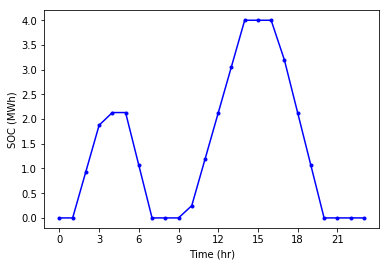

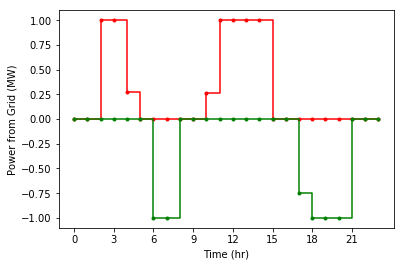

In [18]:
# Plot the state of charge (E)
plt.figure()
plt.plot(time,E_control,'b.-')
plt.xlabel('Time (hr)')
plt.ylabel('SOC (MWh)')
plt.xticks(range(0,24,3))
plt.show()

# Plot the charging and discharging rates
plt.figure()
plt.step(time,c_control,'r.-',where="post")
plt.step(time,d_control,'g.-',where="post")
plt.xlabel('Time (hr)')
plt.ylabel('Power from Grid (MW)')
plt.xticks(range(0,24,3))
plt.show()

# At home: switch this to a stair plot as control actions are constant over the hour.

### 10e-vii. How much money can a 4 MWh battery make in a year?

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Copy the code from 10e-iv to the cell below. Then modify to calculate the revenue for an entire year. Record your answer on the handout. Hint: Do NOT modify the function `create_model`.
</div>

In [19]:
### BEGIN SOLUTION
# Build the model
entire_year = build_model(data["Price"][:],0.0)

# Specify the solver
solver = SolverFactory('ipopt')

# Solve the model
entire_year_results = solver.solve(entire_year, tee = True)

print("Revenue in 2015: $",value(entire_year.OBJ))

### END SOLUTION


Ipopt 3.12.8: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    35039
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:    26280
                     variables with only lower bounds:        0
                variables with lower and upper bounds:    26280
                     variables with only upper bounds:        0
Total